Humanities Data Analysis: Case studies with Python
--------------------------------------------------
Folgert Karsdorp, Mike Kestemont & Allen Riddell
Chapter 9: A Topic Model of United States Supreme Court Opinions, 1900-2000

## Topic Modelling

<img src="img/timeline.png"/>

Pros:
  - well-established: "evergreen" in CLS
  - unsupervised (no labeling requires, less biased, etc.)

Cons:
  - challenging to reproduce (because so many settings)
  - coarse: less suitable for fine-grained analyses
  - slow...
  
Topics models are a **family** of modelling techniques, rather than a single method. All models may start from the same base assumptions (and often lead to similar results), but they are often implemented using different algorithms. We'll cover two well-known methods today: **Latent Dirichlet Allocation** (*book chapter*, part 1) and **Non-Negative Matrix Factorization** (*Harry Potter case study*, part 2).

Before we start: what goes in the block below?

In [5]:
import numpy.random; numpy.random.seed(1)
import random; random.seed(1)

## 9.2 Mixture Models: Artwork Dimensions in the Tate Galleries

### Simulated example




Let us draw some numbers (10000) from a normal distribution, parametrized by a given $\mu$ and a given $\sigma$:

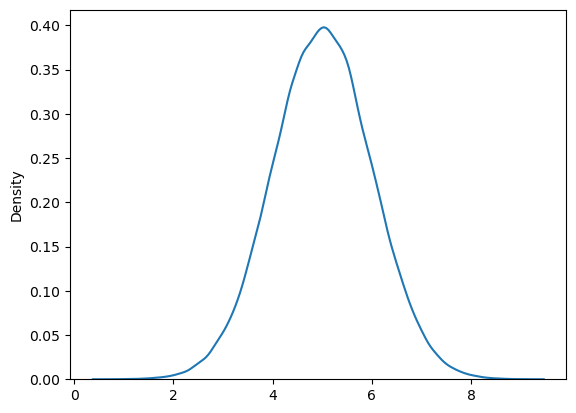

In [8]:
import numpy as np
import seaborn as sns

s1 = np.random.normal(5., 1., 100000)
ax = sns.kdeplot(s1);

If we plot a kernel density estimate for the resulting array, we obtain a clear bell shape. Nothing new so far.

We can draw another array of numbers, using a different $\mu$ and $\sigma$, but **tripling** the sample size:

In [11]:
s2 = np.random.normal(10., 2., 300000)
s1[:10]

array([6.62434536, 4.38824359, 4.47182825, 3.92703138, 5.86540763,
       2.6984613 , 6.74481176, 4.2387931 , 5.3190391 , 4.75062962])

We can jointly plot the KDEs for these arrays and inspect how the two bell shapes look slightly diffferent. Note how they overlap a little in the middle:

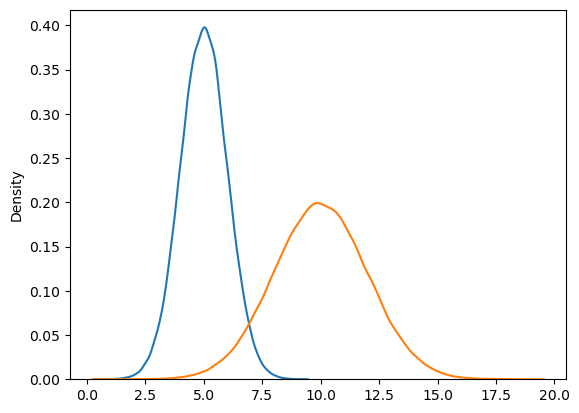

In [13]:

ax = sns.kdeplot(s1);
sns.kdeplot(s2, ax=ax);

Here, we obtain two, separate and rather clean samples that are both quasi-perfectly normally distributed. But what if, because of some historical accident, the two datasets got mingled and we don't know any longer that there ever were two samples. What would happen if the two samples got **mixed up** and we wouldn't know any longer which number was drawn from which distribution?

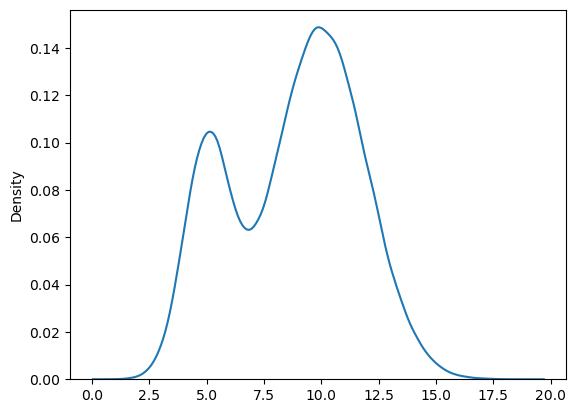

In [15]:
s3 = np.concatenate([s1, s2])
sns.kdeplot(s3);

Fitting a KDE to the **mixture** of those two samples would yield a single density curve, with **two blobs**. Also, the region in between the two peaks is elevated, because here, the two tails of our distribution intersect and reinforce each other.

Fitting this data with a single, normal (with a single $\mu$ and $\sigma$) would be theoretically possible, but clearly suboptimal: the resulting normal wouldn't do justice to a fundamental property of the data, namely the fact that is has multiple peaks or modes. We want to acknowledge that our sample seems to derive from a **mixture** of multiple distributions that have been squashed together.

If you have reasons to believe that a sample derives from mixing multiple distributions, it makes sense to model it like that and you have a couple of models at your disposal that enable you to do just that:

In [18]:
import sklearn.mixture as mixture

gmm = mixture.BayesianGaussianMixture(n_components=2, max_iter=200)

In the block above we load a model from `sklearn` that allows us to "fit" a mixture of Normal (AKA Gaussian) distributions. "Fitting" in this context means two things:
- you'll want to figure out the $\mu$ and $\sigma$ for each of the **latent** distributions that got mixed. In our case, we expect there to be two underlying, latent distributions, a hypothesis which we explicitly set with `n_components=2`.
- you'll want to determine the mixing weight for each of the distributions: remember that three times as many values in `s3` come from `s2`; only a quarter comes from `s1`.

We are now ready to fit our model:

In [20]:
gmm.fit(s3.reshape(-1, 1))

BayesianGaussianMixture(max_iter=200, n_components=2)

Let's find out whether the model was able to reconstruct the means of our two mixing distributions:

In [22]:
gmm.means_

array([[5.00376869],
       [9.99712808]])

That's very close to our original parameters! What about the relative weight of each distribution?

In [24]:
gmm.weights_

array([0.24943027, 0.75056973])

Not bad at all: the guessed proportions are very closed to the optimal solutions. In the next example, we'll demonstrate that this is not just a theoretical case: in many you'll want to model data that might a need a **mixture model**.

### Real-world example: Tate Galleries

The Tate galleries consist of four art museums in the United Kingdom. The museums—Tate Britain, Tate Modern in London, Tate Liverpool, and Tate St. Ives in Cornwall—house the United Kingdom’s national collection of British art, as well as an international collection of modern and contemporary art. Tate has made available metadata for approximately 70,000 of its artworks.

In [27]:
import pandas as pd

df = pd.read_csv("data/tate.csv.gz", index_col='artId')
df[["artist", "acquisitionYear", "accession_number", "medium", "width", "height"]].head(2)

,artist,acquisitionYear,accession_number,medium,width,height
artId,,,,,,
1035,"Blake, Robert",1922.0,A00001,"Watercolour, ink, chalk and graphite on paper....",419,394
1036,"Blake, Robert",1922.0,A00002,Graphite on paper,213,311


The `width` and `heigth` columns are expressed in millimeters. There's some really large objects in there:

In [29]:
df['surface'] = df['width'] * df['height']
df.iloc[df['surface'].argmax()]

artistId                                                         2312
artist                                               Therrien, Robert
gender                                                           Male
accession_number                                              AR00166
title                                No Title (Table and Four Chairs)
year                                                             2003
acquisitionYear                                                2008.0
medium                             Aluminium, steel, wood and plastic
dimensions          displayed: 8920 x 14850 mm object, each (Chair...
height                                                           8920
width                                                           14850
subject                          objects,emotions, concepts and ideas
surface                                                     132462000
Name: 98367, dtype: object

The largest object is an giant table set by Robert Therrien:

<img src="img/therrien.png"/>

The smallest object is a really tiny drawing (or an error?) for which we couldn't find an image:

In [32]:
df.iloc[df['surface'].argmin()]

artistId                                           1624
artist                                   Mesens, E.L.T.
gender                                             Male
accession_number                                 T01102
title                                   Thème de Ballet
year                                               1960
acquisitionYear                                  1969.0
medium              Paper and knitting needles on paper
dimensions                           support: 3 x 79 mm
height                                                3
width                                                79
subject                                             NaN
surface                                             237
Name: 9453, dtype: object

Let us filter out the more extreme cases:

In [34]:
df = df.loc[(df['width'] < 8000) & (df['height'] < 8000)]
df = df.loc[(df['width'] >= 20) & (df['height'] >= 20)]

Let us make the very coarse assumption that most of the objects represented in this dataset are flat, two-dimensional objects, such as paintings are drawings. We can visualize the dimensions of a sample as follows:

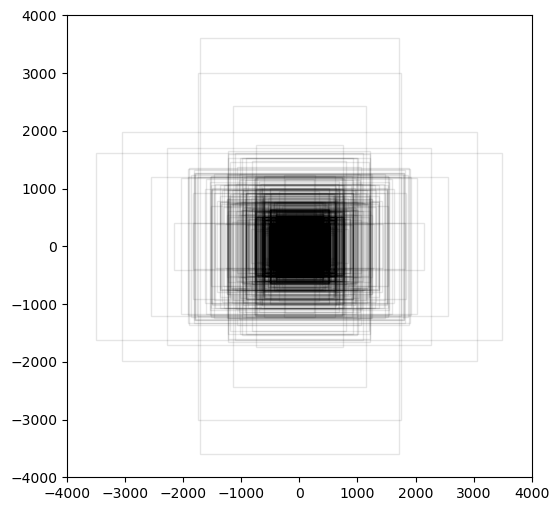

In [36]:
import matplotlib
import matplotlib.pyplot as plt

def create_rectangle(width, height):
    return matplotlib.patches.Rectangle((-(width / 2), -(height / 2)), width, height,
                                         fill=False, alpha=0.1)
fig, ax = plt.subplots(figsize=(6, 6))

sample_ = df.sample(n=10000)
for idx, row in sample_.iterrows():
    ax.add_patch(create_rectangle(row['width'], row['height']))

ax.set(xlim=(-4000, 4000), ylim=(-4000, 4000));

As you can see, most of the objects are to be found cluttered in the middle. Only a minority of objects are larger -- and when they're not in the center of this plot, they quickly get rare and *much* larger. That's is a classic scenario in which you'll want to convert the data to the log scale: 

In [38]:
import numpy as np

df["width_log10"] = np.log10(df["width"])
df["height_log10"] = np.log10(df["height"])

Let us have a look at the distribution of the width and height of the objects: which measurements are common? Note that we will have to remember that our values are on the log scale, with 2 being equal to 100 mm, 3 being equal to 1000 mm, and so on.

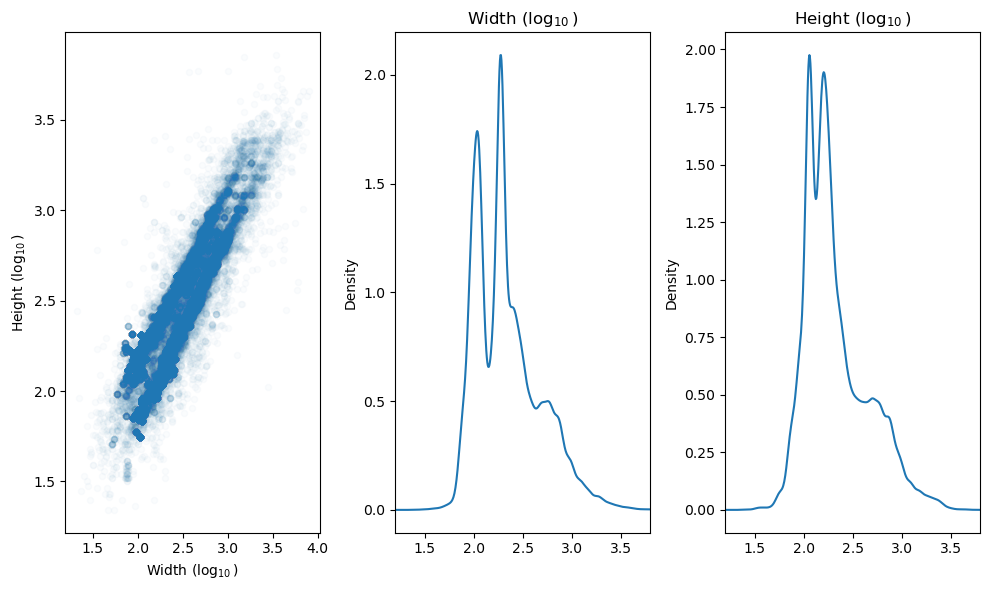

In [40]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(10, 6))
df.plot(x='width_log10', y='height_log10', kind='scatter', alpha=0.02, ax=axes[0])
axes[0].set(xlabel=r'Width ($\log_{10}$)', ylabel=r'Height ($\log_{10}$)')

df['width_log10'].plot(kind='density', title=r'Width ($\log_{10}$)', ax=axes[1])
df['height_log10'].plot(kind='density', title=r'Height ($\log_{10}$)', ax=axes[2])
xlim = (1.2, 3.8); axes[1].set_xlim(*xlim); axes[2].set_xlim(*xlim)
plt.tight_layout();

Another way to plot this data is with `seaborn`'s `jointplot()`:

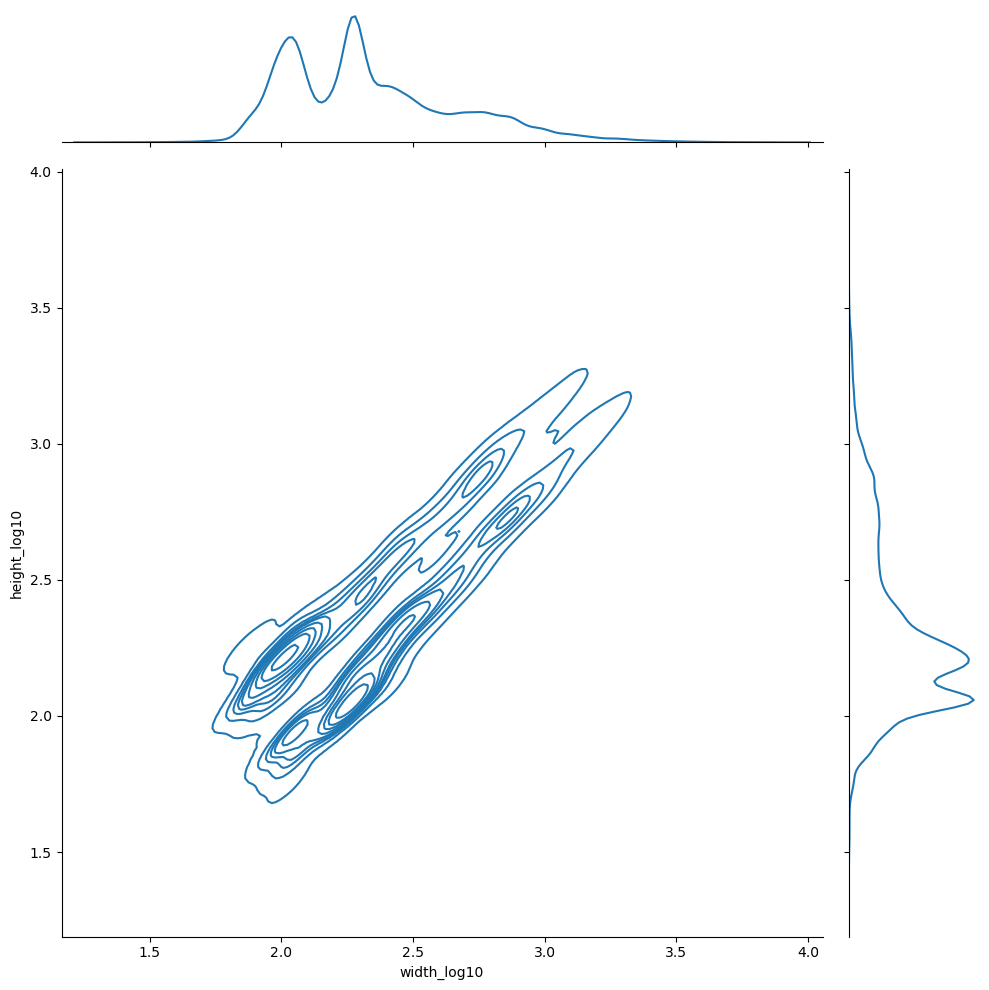

In [42]:
sns.jointplot(data=df, x="width_log10", y="height_log10", height=10, kind='kde');

This graphs too seems to have multiple "peaks" (it's multimodal), instead of a single one. Can you figure out why that might the case? **Which two (or three) cases do these peaks represent?**

Let us fit a same Gaussian mixture to this data (which now has two instead of a single dimension but that shouldn't change anything for us):

In [45]:
np.set_printoptions(suppress=True)  # supress scientific notation

gmm = mixture.BayesianGaussianMixture(n_components=3, max_iter=200)
gmm.fit(df[['width_log10', 'height_log10']])

# order of components is arbitrary, sort by mixing proportions (decending)
order = np.argsort(gmm.weights_)[::-1]
means, covariances, weights = gmm.means_[order], gmm.covariances_[order], gmm.weights_[order]

# mu_1, mu_2, mu_3 in the equation above
print("μ's =", means.round(2))
# Sigma_1, Sigma_2, Sigma_3 in the equation above
print("Σ's =", covariances.round(4))
# theta_1, theta_2, theta_3 in the equation above
print("θ's =", weights.round(2))

μ's = [[2.45 2.4 ]
 [2.01 2.21]
 [2.27 2.05]]
Σ's = [[[0.1114 0.1072]
  [0.1072 0.1283]]

 [[0.0047 0.0042]
  [0.0042 0.0047]]

 [[0.0001 0.0001]
  [0.0001 0.0001]]]
θ's = [0.68 0.21 0.11]


In the following, rather complex code block we visualize the result of our model, with a representation of the three latent classes that were detected:

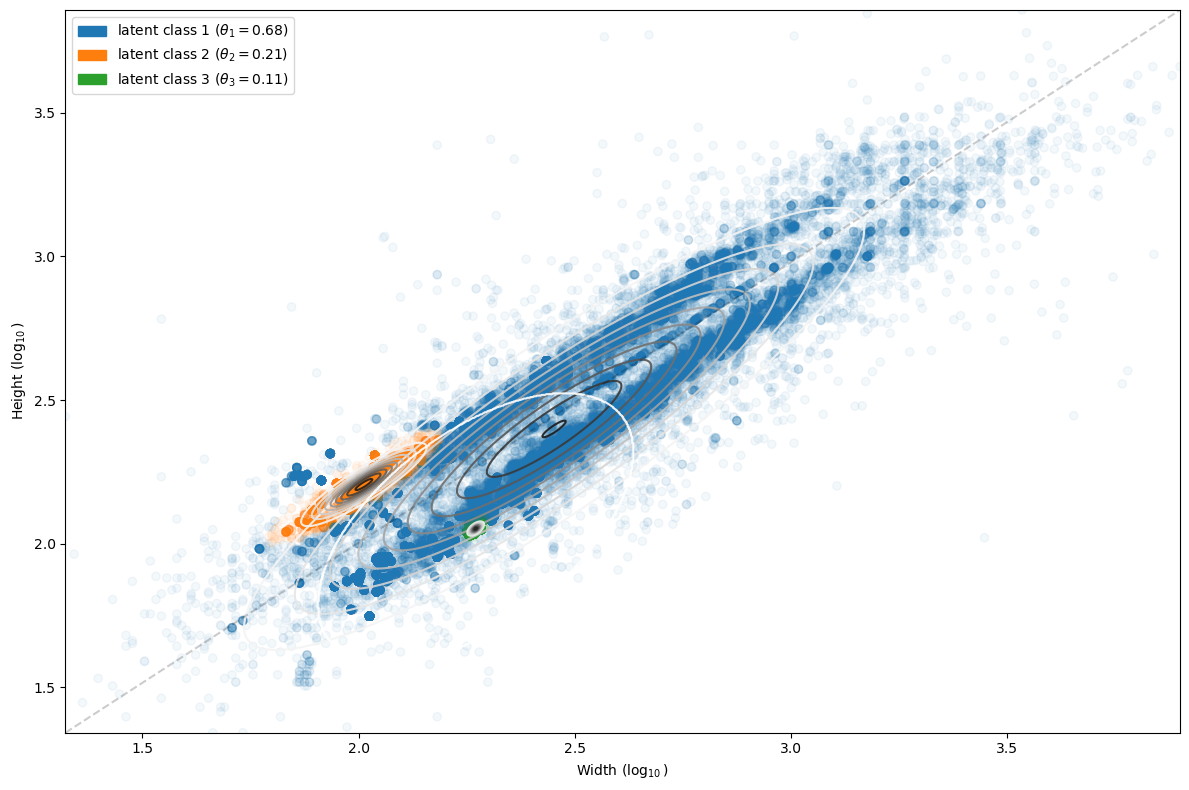

In [47]:
import scipy.stats
import matplotlib.patches

# reorder responsibilties
responsibilities = gmm.predict_proba(df[['width_log10', 'height_log10']])[:, order]

color_predicted = [f'C{i}' for i in responsibilities.argmax(axis=1)]

x = np.linspace(df['width_log10'].min(), df['width_log10'].max(), 1000)
y = np.linspace(df['height_log10'].min(), df['height_log10'].max(), 1000)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(figsize=(12, 8))

for i, (mu, Sigma) in enumerate(zip(means, covariances)):
    pdf = scipy.stats.multivariate_normal(mean=mu, cov=Sigma).pdf
    Z = pdf(np.column_stack([X.ravel(), Y.ravel()])).reshape(X.shape)
    CS = ax.contour(X, Y, Z, 10, alpha=0.9, cmap="Greys")

ax.scatter(df['width_log10'], df['height_log10'],
           color=color_predicted, alpha=0.05)
ax.set(xlabel=r'Width ($\log_{10}$)', ylabel=r'Height ($\log_{10}$)')

patches = [
    matplotlib.patches.Patch(color=f'C{i}', label=rf'latent class {i+1} ($\theta_{i+1} = {theta:.2f}$)')
    for i, theta in enumerate(weights)
]
plt.legend(handles=patches)
plt.plot([0, 1], [0, 1], transform=ax.transAxes, alpha=0.2, linestyle='--', color="black") # diagonal line
plt.tight_layout();

Why should we care about this? Because topic models also model documents as mixtures, but this time of distinct topics. [*Move to slides*.]

*Start running **all the cells below** already!*

## 9.3 Mixed-Membership Model of Texts

Below, we'll model the history of the US Supreme Court through its published **opinions**, which are shorter documents written by one or more judges, often called "Justices". We load this data:

In [3]:
import os
import gzip
import pandas as pd

with gzip.open('/Users/arashalborz/Digital Text Analysis/Computational Literary Studies/Lectures/session-08/06-topic-models/data/supreme-court-opinions-by-author.jsonl.gz', 'rt') as fh:
    df = pd.read_json(fh, lines=True).set_index(['us_reports_citation', 'authors'])

We display records associated with the 1944 decision *Korematsu v. United States*, which ordered Japanese Americans, including those who were United States citizens, into internment camps.

In [4]:
df.head()

case_id  \
us_reports_citation authors              
415 US 361          brennan   1973-067   
                    douglas   1973-067   
180 US 506          harlan_i  1900-132   
65 US 376           grier     1860-047   
344 US 624          minton    1952-049   

                                                                           text  \
us_reports_citation authors                                                       
415 US 361          brennan   \nOPINION BY: BRENNAN\nOPINION\nMR. JUSTICE BR...   
                    douglas   \nDISSENT BY: DOUGLAS\nMR. JUSTICE DOUGLAS, di...   
180 US 506          harlan_i  \nOPINION BY: HARLAN\nOPINION\nMR. JUSTICE HAR...   
65 US 376           grier     \nOPINION BY: GRIER\nOPINION\nMr. Justice GRIE...   
344 US 624          minton    \nOPINION BY: MINTON\nOPINION\nMR. JUSTICE MIN...   

                                 type  year  
us_reports_citation authors                  
415 US 361          brennan   opinion  1974  
                    douglas   dissent  1974  
180 US 506          harlan_i  opinion  1901  
65 US 376           grier     opinion  1861  
344 US 624          minton    opinion  1953

In [5]:
df.loc['323 US 214']

,case_id,text,type,year
authors,,,,
black,1944-018,\nOPINION BY: BLACK\nOPINION\nMR. JUSTICE BLAC...,opinion,1944
frankfurter,1944-018,\nCONCUR BY: FRANKFURTER\nMR. JUSTICE FRANKFUR...,concur,1944
roberts_o,1944-018,\nDISSENT BY: ROBERTS; MURPHY; JACKSON\nMR. JU...,dissent,1944
murphy,1944-018,"\nMR. JUSTICE MURPHY, dissenting.\nThis exclus...",dissent,1944
jackson_r,1944-018,"\nMR. JUSTICE JACKSON, dissenting.\nKorematsu ...",dissent,1944


(The "type" reflects whether a particular justice wrote a document that reflected the official (majority) opinion of the Court, whether they "concurred" or whether they "dissented".) We can instead the beginning of Murphy's dissenting document in this case:

In [6]:
print(df.loc['323 US 214'].loc['murphy', 'text'][:500])


MR. JUSTICE MURPHY, dissenting.
This exclusion of "all persons of Japanese ancestry, both alien and non-alien," from the Pacific Coast area on a plea of military necessity in the absence of martial law ought not to be approved.  Such exclusion goes over "the very brink of constitutional power" and falls into the ugly abyss of racism.
In dealing with matters relating to the prosecution and progress of a war, we must accord great respect and consideration to the judgments of the military authorit


The histogram below shows that the corpus includes 34,677 texts published between 1794 and 2008:

count    34677.000000
mean      1928.824552
std         48.821262
min       1794.000000
25%       1890.000000
50%       1927.000000
75%       1974.000000
max       2008.000000
Name: year, dtype: float64


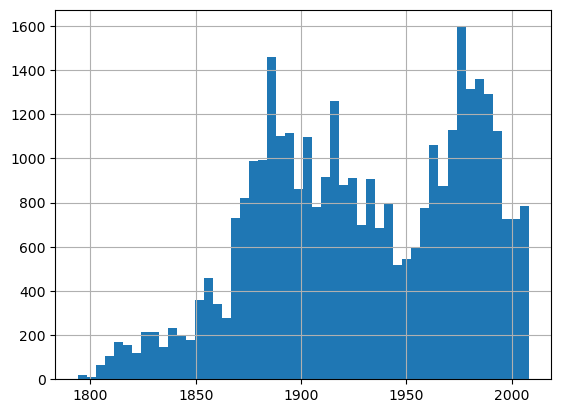

In [7]:
print(df['year'].describe())
df['year'].hist(bins=50);

Topic models are (yet another example of) bag of words models: they only care about the word frequencies in documents, not about word order and syntax. We extract a word frequency matrix as follows:

In [8]:
import sklearn.feature_extraction.text as text

vec = text.CountVectorizer(lowercase=True, min_df=700, stop_words='english') # increased min_df to save time...
dtm = vec.fit_transform(df['text'])

We obtain a largish matrix:

In [9]:
print(f'Shape of document-term matrix: {dtm.shape}. '
      f'Number of tokens {dtm.sum()}')

Shape of document-term matrix: (34677, 4835). Number of tokens 31887461


We will now fit our LDA model (*see slides*): note that the primary parameter which we have to set in advance is the number of topics (which is a tradeoff between the granularity and vagueness of the topics that we'll get). It's common to use less than 500 topics.

In [10]:
import sklearn.decomposition as decomposition
model = decomposition.LatentDirichletAllocation(
    n_components=30, learning_method='online', random_state=1)

We can now `fit` the model and then proceed to the `transform`-part: the latter, in the case of LDA, comes down to what is known as the inference step. We are inferring what the mixing proportion is for each of the 100 topics in each of the documents that we fitted on. (Note that LDA is an unsupervised method, so that we can twice use the same dataset.)

In [11]:
document_topic_distributions = model.fit_transform(dtm)

For inspecting what our topic model produced, we'll need three ingredients:
- the words in our vocabulary
- the model's topics
- the distribution of topics inferred for each of the documents

In [12]:
vocabulary = vec.get_feature_names_out()
# (# topics, # vocabulary)
#assert model.components_.shape == (100, len(vocabulary))
# (# documents, # topics)
#assert document_topic_distributions.shape == (dtm.shape[0], 100)

Let us first see which words are most strongly represented inside each topic. We put the topic weights and document weights inside two separate dataframes for this purposes:

In [13]:
topic_names = [f'Topic {k}' for k in range(30)]
topic_word_distributions = pd.DataFrame(
    model.components_, columns=vocabulary, index=topic_names)
document_topic_distributions = pd.DataFrame(
    document_topic_distributions, columns=topic_names, index=df.index)

Let's us have a look at the mixing weights for one of the previously mentioned documents:

In [14]:
document_topic_distributions.loc['323 US 214'].loc['murphy'].head(10)

Topic 0    0.031804
Topic 1    0.005562
Topic 2    0.000047
Topic 3    0.000047
Topic 4    0.017426
Topic 5    0.153733
Topic 6    0.000047
Topic 7    0.096494
Topic 8    0.000047
Topic 9    0.012721
Name: murphy, dtype: float64

You'll notice that most of the weights are tiny: this is common in LDA models, where the mixing weight for individual documents will often be dominated by just a few weights. (We should be comfortable with the intuition that most individual Supreme Court opinions only deal with a tiny subset of the range of recurrent legal issues appearing in the corpus). This is also shown in the following graph, where we show the mixing weights for a random sample of documents

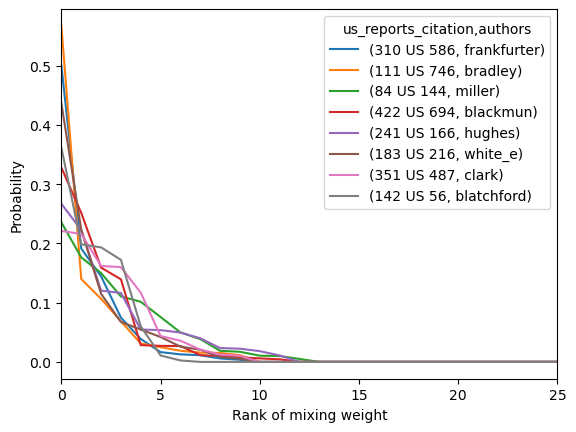

In [15]:
weights_sample = document_topic_distributions.sample(8)
weights_ordered = weights_sample.apply(
    lambda row: row.sort_values(ascending=False).reset_index(drop=True), axis=1)
# transpose DataFrame so pandas plots weights on correct axis
ax = weights_ordered.T.plot()
ax.set(xlabel='Rank of mixing weight', ylabel='Probability', xlim=(0, 25));

This is a so-called rank-abundance curve that shows how, typically, only a few topics dominate an individual documents, although there is some heterogeniety in how quickly the curves wane.

But, now, what is the semantic content of these topics?

In [16]:
murphy_dissent = document_topic_distributions.loc['323 US 214'].loc['murphy']
murphy_dissent.sort_values(ascending=False).head(10)

Topic 22    0.238031
Topic 5     0.153733
Topic 12    0.149099
Topic 18    0.113858
Topic 7     0.096494
Topic 27    0.081187
Topic 24    0.035464
Topic 0     0.031804
Topic 17    0.026934
Topic 11    0.024145
Name: murphy, dtype: float64

Topic models are, in a way, agnostic of the topics that they themselves have assembled: they just group words together that often co-appear but have no clue as the underlying **semantic** reasons that cause this. We therefore have to interpret ourselves what a topic might represent. To achieve that, we turn our other dataframe and retrieve which words are most strongly associated with this topic:

> *Note*: because of the random initialization of LDA, you might end up with slightly different results. For the same reason, you might have to fill in another topic index below.

In [17]:
topic_word_distributions.loc['Topic 8'].sort_values(ascending=False).head(18)

new              40071.782304
york             22884.756255
insurance        16524.016247
policy           12198.043870
plan              9243.694207
life              5576.907945
jersey            5461.912877
insured           3754.402359
policies          3352.222701
massachusetts     3311.635958
law               3241.183979
benefit           3002.929775
virginia          2736.807496
company           2592.427646
state             2520.299477
ins               2395.161384
application       2307.308607
plans             2239.105747
Name: Topic 8, dtype: float64

### 9.3.2 Checking an unsupervised model
*We'll skip this section in class.*


### 9.3.3 Modeling different word senses
*We'll skip this section in class.*

### 9.3.4 Exploring trends over time in the Supreme Court

Before we move on to the literary case study, we'll illustrate one very common application of topic models, which are **time series**: which topics became more prominent, for instance, over time? Below, you can select a random topic and plot its trajectory over time. In the next part, we'll use use Kendall's $\tau$ to automatically select potentially relevant topics.

In [18]:
labor_topic = 'Topic 24'
topic_word_distributions.loc[labor_topic].sort_values(ascending=False).head(10)

power           57723.180484
states          52708.709531
law             42441.425719
state           40613.774665
congress        35659.623262
constitution    34205.818745
act             26917.013516
united          25333.376007
laws            21759.126649
authority       21113.294143
Name: Topic 24, dtype: float64

In [19]:
topic_top_words = topic_word_distributions.loc[labor_topic].sort_values(
    ascending=False).head(10).index
topic_top_words_joined = ', '.join(topic_top_words)
print(topic_top_words_joined)

power, states, law, state, congress, constitution, act, united, laws, authority


In [21]:
import numpy as np
# convert `dtm` (matrix) into an array:
opinion_word_counts = np.array(dtm.sum(axis=1)).ravel()
word_counts_by_year = pd.Series(opinion_word_counts).groupby(df.year.values).sum()
topic_word_counts = document_topic_distributions.multiply(opinion_word_counts,
                                                          axis='index')
topic_word_counts_by_year = topic_word_counts.groupby(df.year.values).sum()
topic_proportion_by_year = topic_word_counts_by_year.divide(word_counts_by_year,
                                                            axis='index')

In [22]:
topic_proportion_by_year.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
1794,0.000140,0.029478,0.077420,0.000140,0.000140,0.000140,0.000140,0.088940,0.000140,0.000140,...,0.000140,0.000140,0.000140,0.000140,0.174673,0.066444,0.000140,0.270146,0.013123,0.000140
1795,0.013568,0.140844,0.000102,0.000102,0.012495,0.037687,0.000102,0.293859,0.000102,0.036667,...,0.005656,0.000102,0.000102,0.000102,0.080374,0.000102,0.002184,0.039558,0.000102,0.000102
1796,0.000102,0.013848,0.000102,0.026323,0.000102,0.000102,0.010234,0.028368,0.002258,0.006429,...,0.000459,0.006207,0.000102,0.004423,0.360283,0.000102,0.000102,0.085052,0.022948,0.001017
1797,0.000097,0.031733,0.000097,0.062560,0.000097,0.004472,0.000097,0.043537,0.000097,0.000097,...,0.000097,0.006342,0.000097,0.003492,0.065366,0.000097,0.000097,0.143533,0.213875,0.000097
1798,0.000038,0.008750,0.035309,0.000038,0.000038,0.005944,0.000038,0.000947,0.018895,0.089492,...,0.000595,0.000038,0.011181,0.000038,0.735526,0.000038,0.001804,0.042270,0.000038,0.012604


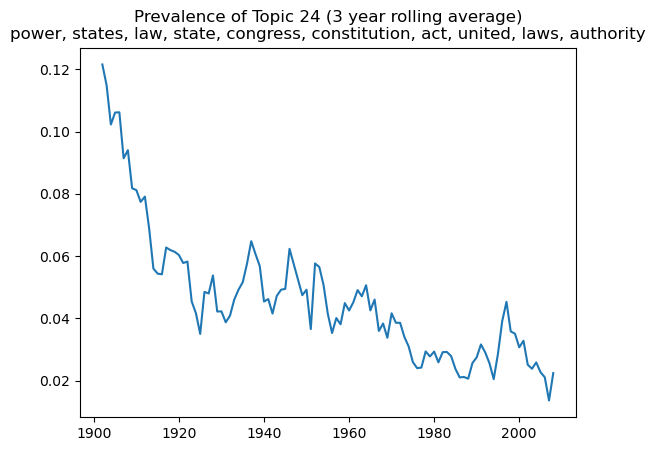

In [23]:
import matplotlib.pyplot as plt

window = 3
topic_proportion_rolling = topic_proportion_by_year.loc[1900:, labor_topic].rolling(
    window=window).mean()
topic_proportion_rolling.plot()
plt.title(f'Prevalence of {labor_topic} ({window} year rolling average)'
          f'\n{topic_top_words_joined}');